In [1]:
# Add this near the top of your script, after the imports
import jax
import sys

print(f"JAX running on: {jax.default_backend()}")
if jax.default_backend() != 'gpu':
    print("WARNING: JAX is not using the GPU. Check your JAX installation and CUDA setup.", file=sys.stderr)
else:
    print("✅ JAX is using the GPU.")

# You can also list all available devices
print("Available devices:")
for device in jax.devices():
    print(f"- {device}")

JAX running on: cpu
Available devices:
- TFRT_CPU_0


Loading simulation data from data_for_PIN.pkl...
Data loading complete.
Starting training for 2000 epochs...
Epoch 1/2000 | Train Loss: 1.0125 | Val Loss: 0.9820 | Data: 1.0124 | Phys: 0.0158 | Cons: 0.0104 | Diss: 0.0052 | H_Loss: 0.2720
Epoch 100/2000 | Train Loss: 0.6366 | Val Loss: 0.6204 | Data: 0.6349 | Phys: 0.0163 | Cons: 0.0004 | Diss: 0.0004 | H_Loss: 0.2718
Epoch 200/2000 | Train Loss: 0.1526 | Val Loss: 0.1540 | Data: 0.1445 | Phys: 0.0170 | Cons: 0.0110 | Diss: 0.0125 | H_Loss: 0.1693
Epoch 300/2000 | Train Loss: 0.1133 | Val Loss: 0.1151 | Data: 0.1042 | Phys: 0.0156 | Cons: 0.0070 | Diss: 0.0078 | H_Loss: 0.1669
Epoch 400/2000 | Train Loss: 0.0990 | Val Loss: 0.1010 | Data: 0.0890 | Phys: 0.0144 | Cons: 0.0046 | Diss: 0.0059 | H_Loss: 0.1624
Epoch 500/2000 | Train Loss: 0.0932 | Val Loss: 0.0944 | Data: 0.0806 | Phys: 0.0136 | Cons: 0.0064 | Diss: 0.0051 | H_Loss: 0.1612
Epoch 600/2000 | Train Loss: 0.0869 | Val Loss: 0.0887 | Data: 0.0750 | Phys: 0.0126 | Cons: 0.0032 |

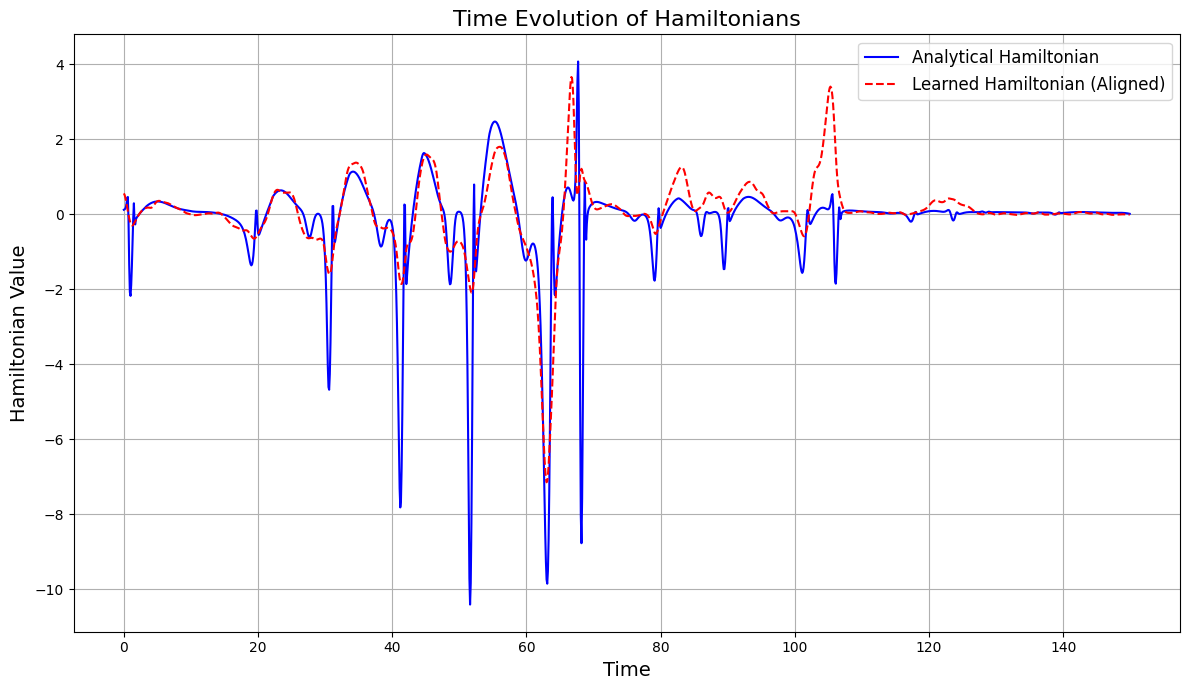

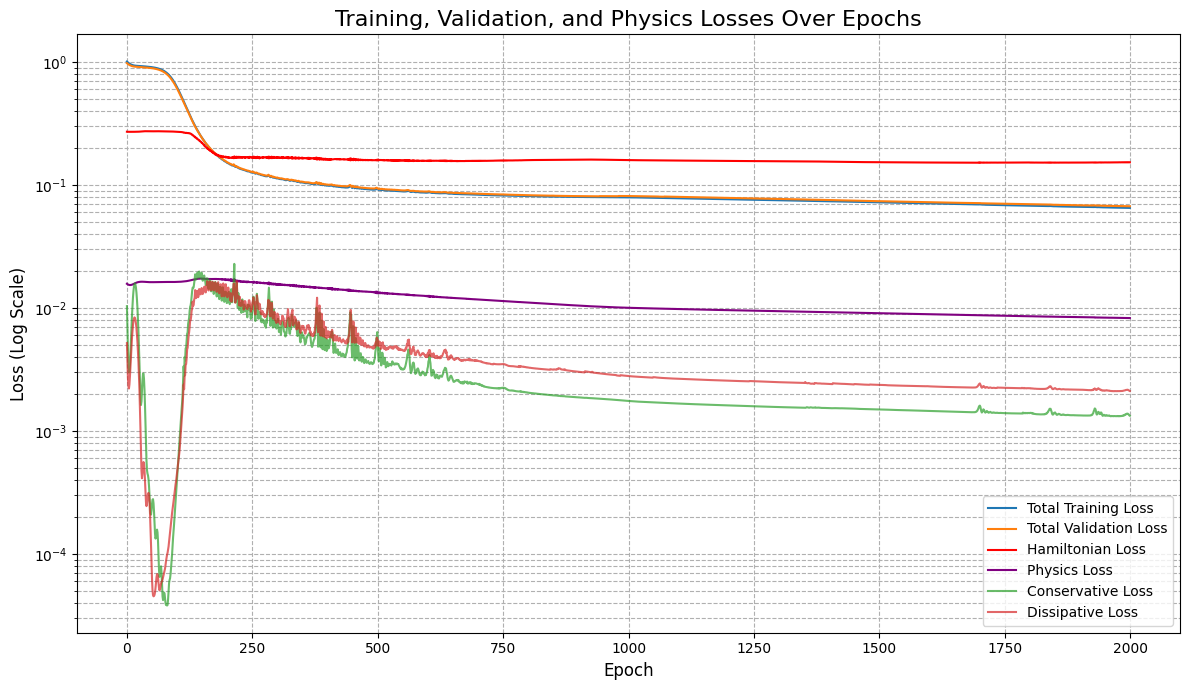

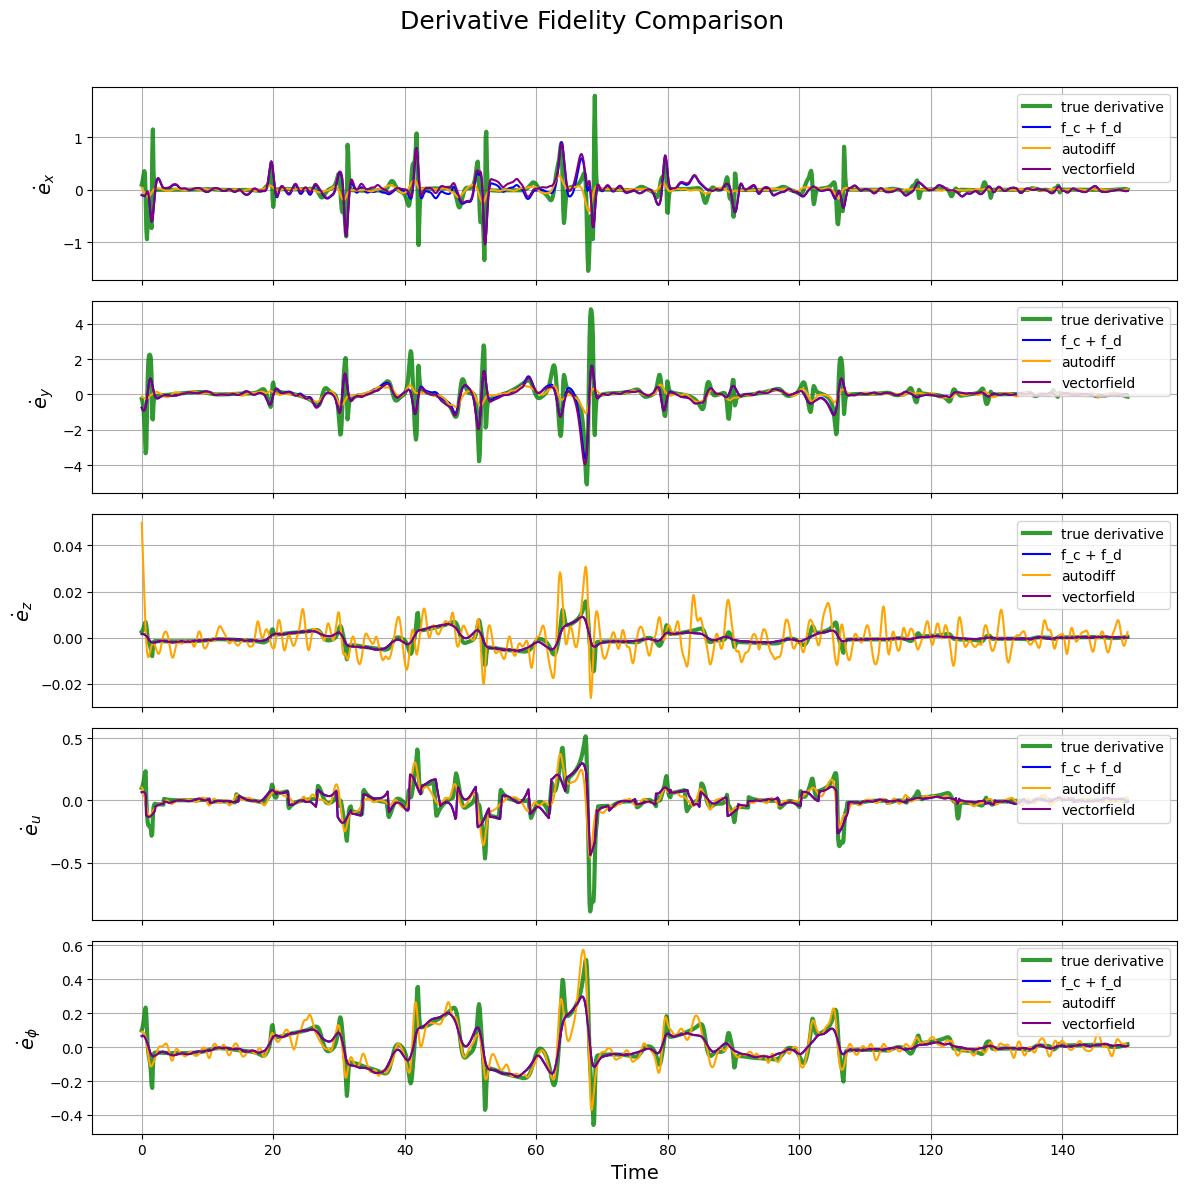

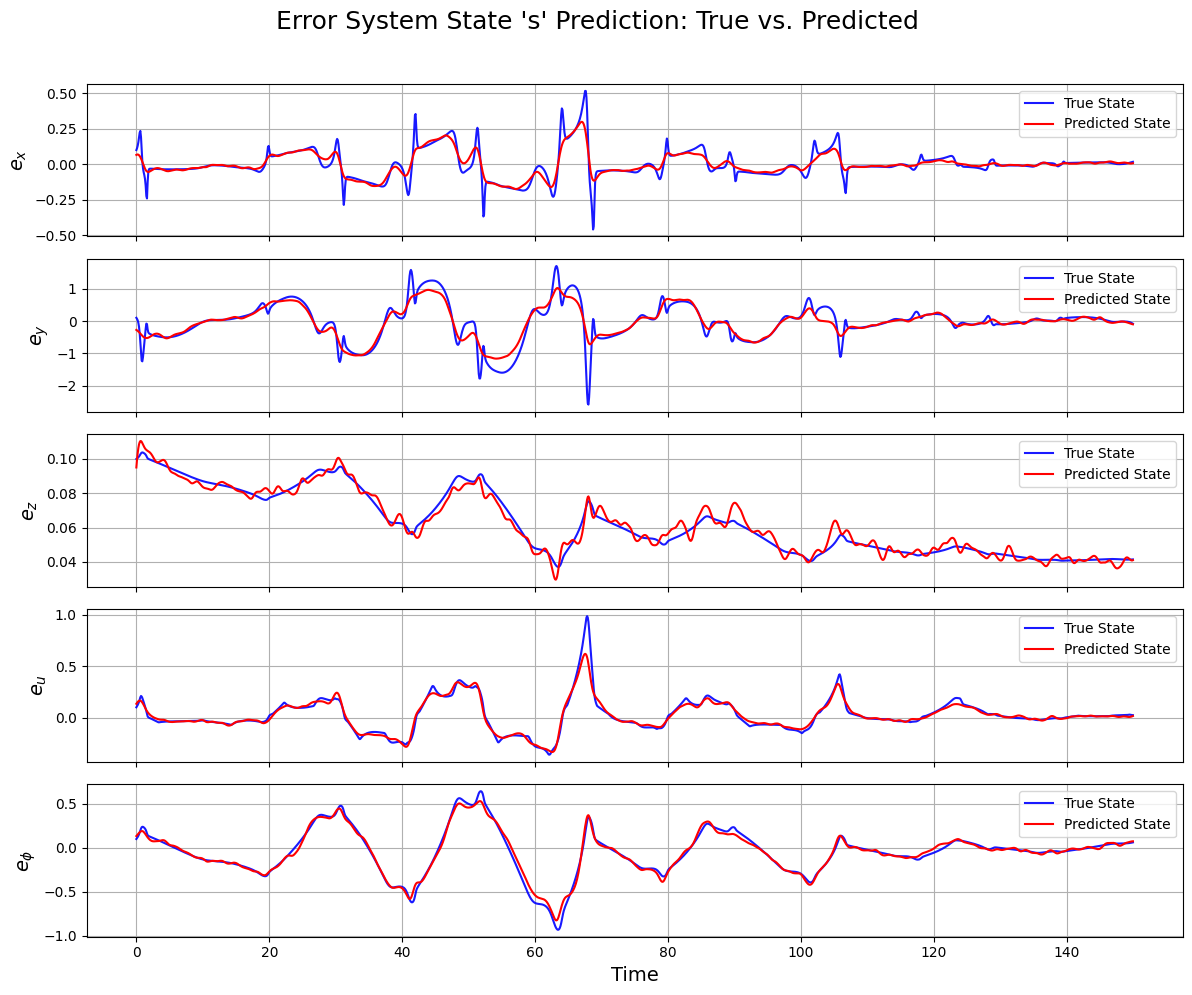

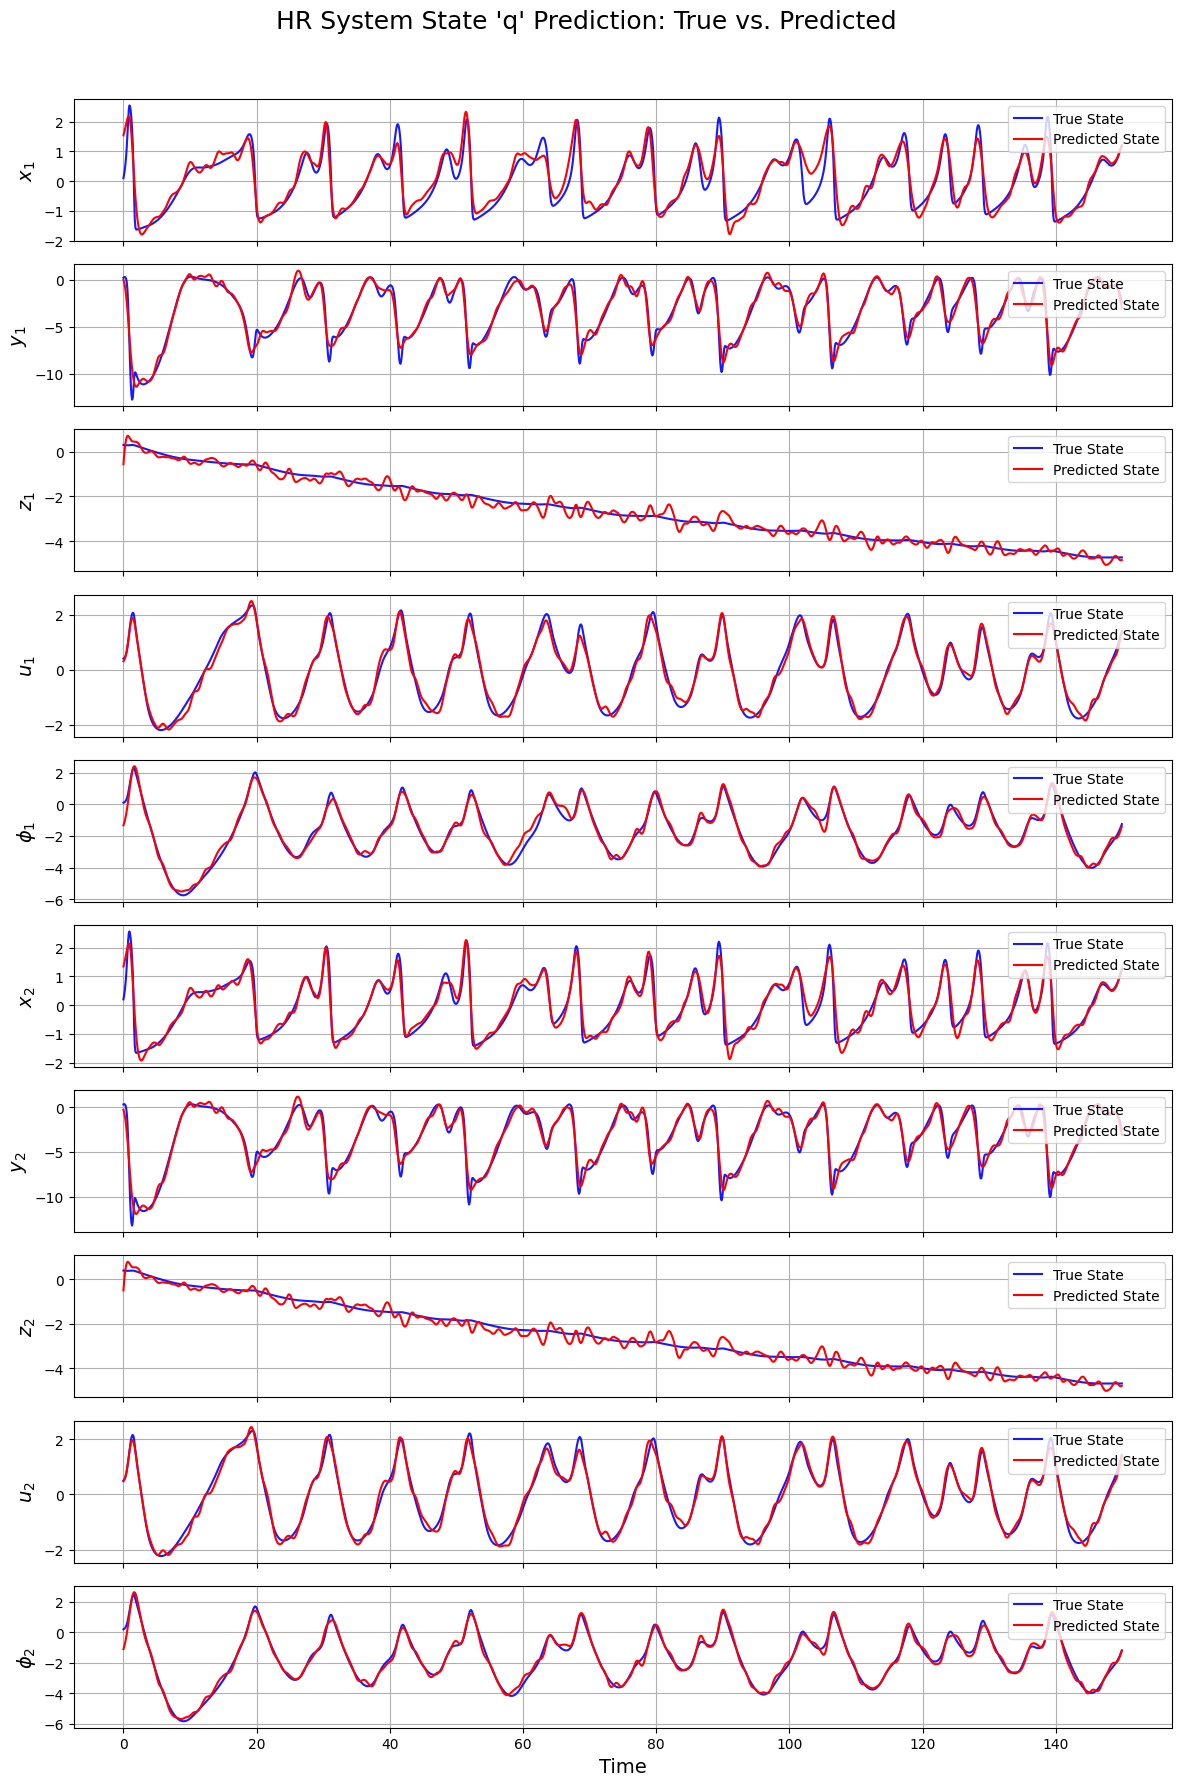

In [2]:
"""
This script implements a Physics-Informed Stable Port-Hamiltonian Neural Network.
The model learns the underlying physical structure of an error-feedback system
by training a composite model that simultaneously predicts the system's state
and enforces physical constraints.

The model is composed of two main parts:
1.  State Prediction Network: An MLP with Fourier features (StateNN)
    learns the combined state trajectories q(t) and s(t).
2.  Hamiltonian Network: A convex network (HamiltonianNN) learns the system's
    energy function H(s).

The training loss is a combination of:
- Data Fidelity Loss: MSE between predicted states and true data.
- Conservative Loss: Enforces that the learned Hamiltonian is invariant
  under the conservative flow (Lie derivative is zero).
- Dissipative Loss: Enforces that the time derivative of the Hamiltonian
  is correctly described by the dissipative flow, calculated using the
  analytical vector field.
"""

import jax, jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pickle
import sys
from Error_System import HRNetworkErrorSystem
from NeuralModel import HindmarshRose, DEFAULT_PARAMS

# JAX configuration to use 64-bit precision.
jax.config.update("jax_enable_x64", True)

# ==============================================================================
# 1. NEURAL NETWORK DEFINITIONS
# ==============================================================================
class FourierFeatures(eqx.Module):
    """Encodes a 1D input into a higher-dimensional space using Fourier features."""
    b_matrix: jax.Array

    def __init__(self, key, in_size=1, mapping_size=32, scale=1):
        self.b_matrix = jax.random.normal(key, (mapping_size // 2, in_size)) * scale

    def __call__(self, t):
        if t.ndim == 1:
            t = t[None, :]
        t_proj = t @ self.b_matrix.T
        return jnp.concatenate([jnp.sin(t_proj), jnp.cos(t_proj)], axis=-1).squeeze()


class StateNN(eqx.Module):
    """An MLP with Fourier Features to approximate the combined state [q(t), s(t)]."""
    layers: list

    def __init__(self, key, out_size=15, width=128, depth=3, mapping_size=32, scale=300):
        fourier_key, *layer_keys = jax.random.split(key, depth + 1)
        self.layers = [
            FourierFeatures(fourier_key, in_size=1, mapping_size=mapping_size, scale=scale),
            eqx.nn.Linear(mapping_size, width, key=layer_keys[0]),
            *[eqx.nn.Linear(width, width, key=key) for i in range(1, depth - 1)],
            eqx.nn.Linear(width, out_size, key=layer_keys[-1])
        ]

    def __call__(self, t):
        x = self.layers[0](t)
        for layer in self.layers[1:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)


class _FICNN(eqx.Module):
    """Internal helper class for a Fully Input Convex Neural Network."""
    w_layers: list
    u_layers: list
    final_layer: eqx.nn.Linear
    activation: callable = eqx.field(static=True)

    def __init__(self, key, in_size: int, out_size: int, width: int, depth: int):
        self.activation = jax.nn.softplus
        keys = jax.random.split(key, depth)
        self.w_layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        self.w_layers.extend([eqx.nn.Linear(in_size, width, key=key) for key in keys[1:-1]])
        self.u_layers = [eqx.nn.Linear(width, width, use_bias=False, key=key) for key in keys[1:-1]]
        self.final_layer = eqx.nn.Linear(width, out_size, use_bias=False, key=keys[-1])

    def __call__(self, s):
        z = self.activation(self.w_layers[0](s))
        for i in range(len(self.u_layers)):
            # Enforce non-negative weights for convexity
            u_layer_non_negative = eqx.tree_at(lambda l: l.weight, self.u_layers[i], jnp.abs(self.u_layers[i].weight))
            z = self.activation(u_layer_non_negative(z) + self.w_layers[i + 1](s))
        return self.final_layer(z)[0]


class HamiltonianNN(eqx.Module):
    """Learns a convex Hamiltonian function H(x) with a guaranteed minimum at x0."""
    ficnn: _FICNN
    x0: jax.Array
    epsilon: float = eqx.field(static=True)

    def __init__(self, key, in_size, width, depth, x0, epsilon):
        self.ficnn = _FICNN(key, in_size, out_size=1, width=width, depth=depth)
        self.x0 = x0
        self.epsilon = epsilon

    def __call__(self, x):
        # Implements Equation (10) from the paper
        f_x = self.ficnn(x)
        f_x0 = self.ficnn(self.x0)
        grad_f_x0 = jax.grad(self.ficnn)(self.x0)
        # Normalization term to set H(x0)=0 and grad H(x0)=0
        f_norm = f_x0 + jnp.dot(grad_f_x0, x - self.x0)
        # Regularization term to ensure a strict minimum
        f_reg = self.epsilon * jnp.sum((x - self.x0) ** 2)
        return f_x - f_norm + f_reg


# --- The Combined Model ---
class Combined_sPHNN_PINN(eqx.Module):
    """Main model combining a unified state predictor and a Hamiltonian network."""
    state_net: StateNN
    hamiltonian_net: HamiltonianNN

    def __init__(self, key, config):
        state_key, h_key = jax.random.split(key, 2)
        state_dim = config['state_dim']
        # The equilibrium point for the normalized error system is the origin.
        x0_norm = jnp.zeros(state_dim)

        self.state_net = StateNN(key=state_key)
        self.hamiltonian_net = HamiltonianNN(
            h_key, in_size=state_dim, width=config['h_width'], depth=config['h_depth'],
            x0=x0_norm, epsilon=config['h_epsilon']
        )

# ==============================================================================
# 2. DATA HANDLING
# ==============================================================================

def generate_data(file_path="data_for_PIN.pkl"):
    """Loads and prepares training data from a pre-generated pickle file."""
    print(f"Loading simulation data from {file_path}...")
    try:
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'data_for_PIN.pkl' is in the same directory.")
        return None, None, None, None, None

    t = jnp.asarray(results['t'])
    s = jnp.vstack([
        results['e_x'], results['e_y'], results['e_z'],
        results['e_u'], results['e_phi']
    ]).T
    q = jnp.vstack([
        results['x1'], results['y1'], results['z1'], results['u1'], results['phi1'],
        results['x2'], results['y2'], results['z2'], results['u2'], results['phi2']
    ]).T
    s_dot_true = jnp.vstack([
        results['d_e_x'], results['d_e_y'], results['d_e_z'],
        results['d_e_u'], results['d_e_phi']
    ]).T
    # Load the analytical Hamiltonian
    H_analytical = jnp.asarray(results['Hamiltonian'])

    print("Data loading complete.")
    return t, s, q, s_dot_true, H_analytical


def normalize(data, mean, std):
    """Normalizes data using pre-computed statistics."""
    return (data - mean) / (std + 1e-8)

def denormalize(data, mean, std):
    """Denormalizes data using pre-computed statistics."""
    return data * std + mean


# ==============================================================================
# 3. TRAINING LOGIC
# ==============================================================================

# --- Helper functions for the physics-based loss terms ---

def _alpha(u1, u2, m):
    """Helper function for the dissipative field f_d."""
    conds = [
        jnp.logical_and(u1 >= 1, jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(u1 >= 1, u2 <= -1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 >= 1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 <= -1),
        jnp.logical_and(u1 <= -1, u2 >= 1),
        jnp.logical_and(u1 <= -1, jnp.logical_and(u2 > -1, u2 < 1)),
    ]
    choices = [2*m - 1., -1., -1., 2*m - 1., -1., -1., 2*m - 1.]
    return jnp.select(conds, choices, default=-1.)

def _beta(u1, u2, m):
    """Helper function for the dissipative field f_d."""
    conds = [
        jnp.logical_and(u1 >= 1, jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(u1 >= 1, u2 <= -1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 >= 1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 <= -1),
        jnp.logical_and(u1 <= -1, u2 >= 1),
        jnp.logical_and(u1 <= -1, jnp.logical_and(u2 > -1, u2 < 1)),
    ]
    choices = [
        2*m * (u1 - 1), -4*m, -2*m * (u1 - 1), 0.,
        -2*m * (u1 + 1), 4*m, 2*m * (u1 + 1),
    ]
    return jnp.select(conds, choices, default=0.)

def f_c_fn(e, q, hr_params):
    """Calculates the conservative vector field f_c(e)."""
    e_x, e_y, e_u, e_phi = e[0], e[1], e[3], e[4]
    x1, u1 = q[0], q[3]
    
    k, f, rho, d, r, s = \
        hr_params['k'], hr_params['f'], hr_params['rho'], hr_params['d'], hr_params['r'], hr_params['s']
    
    return jnp.array([
        e_y + 2*k*f*u1*x1*e_u + rho*x1*e_phi,
        -2*d*x1*e_x,
        r*s*e_x,
        e_x,
        e_x
    ])

def f_d_fn(e, q, hr_params):
    """Calculates the dissipative vector field f_d(e)."""
    e_x, e_y, e_z, e_u, e_phi = e[0], e[1], e[2], e[3], e[4]
    x1, u1, phi1, u2 = q[0], q[3], q[4], q[8]

    a, b, k, h, f, rho, g_e, r, q_param, m = \
        hr_params['a'], hr_params['b'], hr_params['k'], hr_params['h'], \
        hr_params['f'], hr_params['rho'], hr_params['ge'], hr_params['r'], \
        hr_params['q'], hr_params['m']

    N_val = -3*a*x1**2 + 2*b*x1 + k*h + k*f*u1**2 + rho*phi1 - 2*g_e
    alpha_val = _alpha(u1, u2, m)
    beta_val = _beta(u1, u2, m)

    return jnp.array([
        N_val * e_x,
        -e_y,
        -r * e_z,
        alpha_val * e_u + beta_val,
        -q_param * e_phi
    ])

@eqx.filter_jit
def loss_fn(model: Combined_sPHNN_PINN, t_batch_norm, s_true_batch_norm, q_true_batch_norm, H_true_batch,
            s_dot_true_batch, lambda_conservative: float, lambda_dissipative: float, lambda_phys: float,
            hr_params: dict, t_mean, t_std, s_mean, s_std, q_mean, q_std):
    """Calculates the composite data and new physics-based losses."""

    # --- Part 1: State Prediction and Unified Data Fidelity Loss ---
    all_states_pred_norm = jax.vmap(model.state_net)(t_batch_norm)
    all_states_true_norm = jnp.concatenate([q_true_batch_norm, s_true_batch_norm], axis=1)
    data_loss = jnp.mean((all_states_pred_norm - all_states_true_norm) ** 2)

    # Slice and denormalize predictions for physics calculations
    q_pred_batch_norm = all_states_pred_norm[:, :10]
    s_pred_batch_norm = all_states_pred_norm[:, 10:]
    s_pred = denormalize(s_pred_batch_norm, s_mean, s_std)
    q_pred = denormalize(q_pred_batch_norm, q_mean, q_std)

    # --- Part 2: Physics Calculations ---
    # Gradient of the learned Hamiltonian (delta H)
    grad_H_norm_fn = jax.vmap(jax.grad(model.hamiltonian_net))
    grad_H_norm = grad_H_norm_fn(s_pred_batch_norm)
    grad_H = grad_H_norm / (s_std + 1e-8)

    # Conservative and dissipative parts of the analytical vector field
    f_c_batch = jax.vmap(f_c_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
    f_d_batch = jax.vmap(f_d_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)

    # s_dot from the complete analytical vector field using predicted states
    s_dot_vectorfield = jax.vmap(
        HRNetworkErrorSystem.complete_vector_field, in_axes=(0, 0, None)
    )(s_pred, q_pred, hr_params)
    
    # s_dot via automatic differentiation (kept for potential analysis)
    get_autodiff_grad_s_slice = lambda net, t: jax.jvp(lambda t_scalar: net(t_scalar)[10:], (t,), (jnp.ones_like(t),))[1]
    s_dot_autodiff_norm = jax.vmap(get_autodiff_grad_s_slice, in_axes=(None, 0))(model.state_net, t_batch_norm)
    s_dot_autodiff = s_dot_autodiff_norm * (s_std / (t_std + 1e-8))


    # --- Part 3: Loss Components ---
    # Conservative Loss: L_fc(H) = f_c . grad(H) should be 0
    lie_derivative = jax.vmap(jnp.dot)(f_c_batch, grad_H)
    loss_conservative = jnp.mean(lie_derivative ** 2)

    # Dissipative Loss: dH/dt from vector field should match dH/dt from dissipative part
    dHdt_from_vectorfield = jax.vmap(jnp.dot)(grad_H, s_dot_autodiff)
    dHdt_from_dissipative_part = jax.vmap(jnp.dot)(grad_H, f_d_batch)
    loss_dissipative = jnp.mean((dHdt_from_vectorfield - dHdt_from_dissipative_part) ** 2)

    s_dot_diss_cons = f_c_batch + f_d_batch

    # --- Hamiltonian Comparison Loss (for monitoring only) ---
    H_learned_batch = jax.vmap(model.hamiltonian_net)(s_pred_batch_norm)
    # Align learned H to true H for the batch to handle arbitrary scale and offset
    H_learned_inverted = H_learned_batch * (-1)
    H_learned_aligned = (H_learned_inverted - jnp.mean(H_learned_inverted) + jnp.mean(H_true_batch))
    loss_hamiltonian = jnp.mean((H_learned_aligned - H_true_batch) ** 2)

    # --- Physical Comparison Loss ---
    loss_phys = jnp.mean((s_dot_true_batch - s_dot_diss_cons) ** 2)

    # --- Part 4: Total Loss ---
    total_loss = (data_loss
                  + (loss_phys * lambda_phys)
                  + (loss_conservative * lambda_conservative)
                  + (loss_dissipative * lambda_dissipative)) 

    loss_components = {
        "total": total_loss,
        "data_unified": data_loss,
        "conservative": loss_conservative,
        "dissipative": loss_dissipative,
        "hamiltonian": loss_hamiltonian,
        "phys": loss_phys,
    }
    return total_loss, loss_components



@eqx.filter_jit
def train_step(model, opt_state, optimizer, t_batch_norm, s_batch_norm, q_batch_norm, H_batch, s_dot_batch,
               lambda_conservative, lambda_dissipative, lambda_phys,  hr_params, t_mean, t_std, s_mean, s_std, q_mean, q_std):

    (loss_val, loss_components), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(
        model, t_batch_norm, s_batch_norm, q_batch_norm, H_batch,
        s_dot_batch, lambda_conservative, lambda_dissipative, lambda_phys,
        hr_params, t_mean, t_std, s_mean, s_std, q_mean, q_std
    )
    
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val, loss_components

@eqx.filter_jit
def evaluate_model(model, t_batch_norm, s_batch_norm, q_batch_norm, H_batch,
                   s_dot_batch, lambda_conservative, lambda_dissipative, lambda_phys,
                   hr_params, t_mean, t_std, s_mean, s_std, q_mean, q_std):
    
    _, loss_components = loss_fn(
        model, t_batch_norm, s_batch_norm, q_batch_norm, H_batch,
        s_dot_batch, 
        lambda_conservative, lambda_dissipative, lambda_phys,
        hr_params,
        t_mean, t_std, s_mean, s_std, q_mean, q_std
    )
    
    return loss_components
# ==============================================================================
# 4. MAIN EXECUTION LOGIC
# ==============================================================================

"""Main function to run the training and evaluation."""
# --- Setup and Hyperparameters ---
key = jax.random.PRNGKey(42)
model_key, data_key = jax.random.split(key)

# Training hyperparameters
batch_size = 8000
validation_split = 0.2
initial_learning_rate = 1e-3
end_learning_rate = 1e-4
decay_steps = 1000
epochs = 2000

# Physics loss hyperparameters with warmup
lambda_conservative_max = 1
lambda_dissipative_max = 1
lambda_phys_max = 1
lambda_warmup_epochs = 1000

# System parameters
hr_params = DEFAULT_PARAMS.copy()

# --- Generate and Prepare Data ---
t, s, q, s_dot_true, H_analytical = generate_data()
if t is None:
    sys.exit("Exiting: Data loading failed.")

num_samples = s.shape[0]
perm = jax.random.permutation(data_key, num_samples)
t_shuffled, s_shuffled, q_shuffled, H_shuffled, s_dot_shuffled = t[perm], s[perm], q[perm], H_analytical[perm], s_dot_true[perm]
t_shuffled = t_shuffled.reshape(-1, 1)

split_idx = int(num_samples * (1 - validation_split))
t_train, t_val = jnp.split(t_shuffled, [split_idx])
s_train, s_val = jnp.split(s_shuffled, [split_idx])
q_train, q_val = jnp.split(q_shuffled, [split_idx])
H_train, H_val = jnp.split(H_shuffled, [split_idx])
s_dot_train, s_dot_val = jnp.split(s_dot_shuffled, [split_idx])


# --- Normalize Data (using ONLY training set statistics) ---
t_mean, t_std = jnp.mean(t_train), jnp.std(t_train)
s_mean, s_std = jnp.mean(s_train, axis=0), jnp.std(s_train, axis=0)
q_mean, q_std = jnp.mean(q_train, axis=0), jnp.std(q_train, axis=0)

t_train_norm = normalize(t_train, t_mean, t_std)
s_train_norm = normalize(s_train, s_mean, s_std)
q_train_norm = normalize(q_train, q_mean, q_std)
t_val_norm = normalize(t_val, t_mean, t_std)
s_val_norm = normalize(s_val, s_mean, s_std)
q_val_norm = normalize(q_val, q_mean, q_std)

# --- Centralized Neural Network Configuration ---
s_dim = s_train.shape[1]
nn_config = {
    "state_dim": s_dim, 
    "h_width": 128, "h_depth": 3, "h_epsilon": 0.4,
    "activation": jax.nn.tanh,
}

# Initialize the combined model
model = Combined_sPHNN_PINN(key=model_key, config=nn_config)

# --- Training Loop ---
lr_schedule = optax.linear_schedule(
    init_value=initial_learning_rate,
    end_value=end_learning_rate,
    transition_steps=decay_steps
)
optimizer = optax.chain(
    optax.adam(learning_rate=lr_schedule)
)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Initialize lists to store loss history
train_losses, val_losses = [], []
conservative_losses, dissipative_losses, hamiltonian_losses, phys_losses = [], [], [], []
best_model, best_val_loss = model, jnp.inf
num_batches = t_train_norm.shape[0] // batch_size
print(f"Starting training for {epochs} epochs...")
for epoch in range(epochs):
    # Loss weight warmup schedule
    warmup_factor = jnp.minimum(1.0, (epoch + 1) / lambda_warmup_epochs)
    current_lambda_conservative = lambda_conservative_max * warmup_factor
    current_lambda_dissipative = lambda_dissipative_max * warmup_factor
    current_lambda_phys = lambda_phys_max * warmup_factor

    # Shuffle training data for the new epoch
    key, shuffle_key = jax.random.split(key)
    perm = jax.random.permutation(shuffle_key, t_train_norm.shape[0])
    t_shuffled = t_train_norm[perm]
    s_shuffled = s_train_norm[perm]
    q_shuffled = q_train_norm[perm]
    H_shuffled_train = H_train[perm]
    s_dot_shuffled_train = s_dot_train[perm]

    # Initialize epoch loss accumulators
    epoch_losses = {k: 0.0 for k in ["total", "data_unified", "conservative", "dissipative", "hamiltonian", "phys"]}

    # Loop over batches
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        t_b, s_b, q_b, H_b, s_dot_b = t_shuffled[start:end], s_shuffled[start:end], q_shuffled[start:end], H_shuffled_train[start:end], s_dot_shuffled_train[start:end]
        
        # Perform a single training step
        model, opt_state, train_loss_val, loss_comps = train_step(
            model, opt_state, optimizer, t_b, s_b, q_b, H_b, s_dot_b,
            current_lambda_conservative, current_lambda_dissipative, current_lambda_phys,
            hr_params,
            t_mean, t_std, s_mean, s_std, q_mean, q_std
        )
        # Accumulate losses from the batch
        for k in epoch_losses:
            if k in loss_comps:
                epoch_losses[k] += loss_comps[k]

    # Calculate average losses for the epoch
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}

    # Evaluate the model on the validation set
    val_loss_comps = evaluate_model(
        model, t_val_norm, s_val_norm, q_val_norm, H_val, s_dot_val,
        current_lambda_conservative, current_lambda_dissipative, current_lambda_phys,
        hr_params,
        t_mean, t_std, s_mean, s_std, q_mean, q_std
    )
    val_loss = val_loss_comps["total"]

    # Store the average losses for plotting
    train_losses.append(avg_losses["total"])
    val_losses.append(val_loss)
    conservative_losses.append(avg_losses["conservative"])
    dissipative_losses.append(avg_losses["dissipative"])
    hamiltonian_losses.append(avg_losses["hamiltonian"])
    phys_losses.append(avg_losses["phys"])

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    # Log progress periodically
    if (epoch + 1) % 100 == 0 or epoch == 0:
        log_str = (
            f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_losses['total']:.4f} | Val Loss: {val_loss:.4f} | "
            f"Data: {avg_losses['data_unified']:.4f} | "
            f"Phys: {avg_losses['phys']:.4f} | "
            f"Cons: {avg_losses['conservative']:.4f} | Diss: {avg_losses['dissipative']:.4f} | "
            f"H_Loss: {avg_losses['hamiltonian']:.4f}"
        )
        print(log_str)

print("\nTraining finished.")
print(f"Best validation loss achieved: {best_val_loss:.6f}")


# ==============================================================================
# 5. VISUALIZATION AND ANALYSIS
# ==============================================================================

print("\nGenerating visualization plots...")
# Use the full, unsplit, time-ordered data for coherent plots
t_test = t.reshape(-1, 1)
s_test, q_test, s_dot_test, H_analytical_vis = s, q, s_dot_true, H_analytical
t_test_norm = normalize(t_test, t_mean, t_std)

# --- Get all model predictions for the full dataset ---
all_states_pred_norm = jax.vmap(best_model.state_net)(t_test_norm)
q_pred_norm = all_states_pred_norm[:, :10]
s_pred_norm = all_states_pred_norm[:, 10:]

s_pred = denormalize(s_pred_norm, s_mean, s_std)
q_pred = denormalize(q_pred_norm, q_mean, q_std)

# --- Calculate derivatives for comparison ---
s_dot_from_equations = jax.vmap(
    HRNetworkErrorSystem.complete_vector_field, in_axes=(0, 0, None)
)(s_pred, q_pred, hr_params)

get_s_slice_autodiff_grad = lambda net, t: jax.jvp(lambda t_scalar: net(t_scalar)[10:], (t,), (jnp.ones_like(t),))[1]
s_dot_autodiff_norm = jax.vmap(get_s_slice_autodiff_grad, in_axes=(None, 0))(best_model.state_net, t_test_norm)
s_dot_autodiff = s_dot_autodiff_norm * (s_std / (t_std + 1e-8))

# ADD THIS CALCULATION
f_c = jax.vmap(f_c_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
f_d = jax.vmap(f_d_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
s_dot_diss_cons = f_c + f_d

# --- Plot 1: Learned vs Analytical Hamiltonian ---
print("Comparing learned Hamiltonian with analytical solution...")
H_learned_norm = jax.vmap(best_model.hamiltonian_net)(s_pred_norm)
H_learned_inverted = H_learned_norm * (-1)
H_learned_aligned = (H_learned_inverted - jnp.mean(H_learned_inverted) + jnp.mean(H_analytical_vis))

plt.figure(figsize=(12, 7))
plt.plot(t_test[:1500], H_analytical_vis[:1500], label='Analytical Hamiltonian', color='blue')
plt.plot(t_test[:1500], H_learned_aligned[:1500], label='Learned Hamiltonian (Aligned)', color='red', linestyle='--')
plt.title("Time Evolution of Hamiltonians", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Hamiltonian Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()


# --- Plot 2: Training, Validation, and Physics Losses ---
plt.figure(figsize=(12, 7))
plt.plot(train_losses, label='Total Training Loss')
plt.plot(val_losses, label='Total Validation Loss')
plt.plot(hamiltonian_losses, label='Hamiltonian Loss', color='red')
plt.plot(phys_losses, label='Physics Loss', color='purple')
plt.plot(conservative_losses, label='Conservative Loss', alpha=0.7)
plt.plot(dissipative_losses, label='Dissipative Loss', alpha=0.7)
plt.yscale('log')
plt.title('Training, Validation, and Physics Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()

# --- Plot 3: Derivative Comparison (Physics Fidelity) ---
fig, axes = plt.subplots(s_test.shape[1], 1, figsize=(12, 12), sharex=True)
state_labels_s_dot = [r'$\dot{e}_x$', r'$\dot{e}_y$', r'$\dot{e}_z$', r'$\dot{e}_u$', r'$\dot{e}_\phi$']
fig.suptitle("Derivative Fidelity Comparison", fontsize=18, y=0.99)

for i in range(s_test.shape[1]):
    axes[i].plot(t_test[:1500], s_dot_test[:1500, i], label='true derivative', color='green', linewidth=3, alpha=0.8)
    axes[i].plot(t_test[:1500], s_dot_diss_cons[:1500, i], label='f_c + f_d', color='blue')
    axes[i].plot(t_test[:1500], s_dot_autodiff[:1500, i], label='autodiff', color='orange')
    axes[i].plot(t_test[:1500], s_dot_from_equations[:1500, i], label='vectorfield', color='purple')

    axes[i].set_ylabel(state_labels_s_dot[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Plot 4: Error System State Trajectories (s) ---
fig, axes = plt.subplots(s_test.shape[1], 1, figsize=(12, 10), sharex=True)
state_labels_error = [r'$e_x$', r'$e_y$', r'$e_z$', r'$e_u$', r'$e_\phi$']
fig.suptitle("Error System State 's' Prediction: True vs. Predicted", fontsize=18, y=0.99)
for i in range(s_test.shape[1]):
    axes[i].plot(t_test[:1500], s_test[:1500, i], 'b', label='True State', alpha=0.9)
    axes[i].plot(t_test[:1500], s_pred[:1500, i], 'r', label='Predicted State')
    axes[i].set_ylabel(state_labels_error[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Plot 5: HR System State Trajectories (q) ---
fig, axes = plt.subplots(q_test.shape[1], 1, figsize=(12, 18), sharex=True)
state_labels_q = [
    r'$x_1$', r'$y_1$', r'$z_1$', r'$u_1$', r'$\phi_1$',
    r'$x_2$', r'$y_2$', r'$z_2$', r'$u_2$', r'$\phi_2$'
]
fig.suptitle("HR System State 'q' Prediction: True vs. Predicted", fontsize=18, y=0.99)
for i in range(q_test.shape[1]):
    axes[i].plot(t_test[:1500], q_test[:1500, i], 'b', label='True State', alpha=0.9)
    axes[i].plot(t_test[:1500], q_pred[:1500, i], 'r', label='Predicted State')
    axes[i].set_ylabel(state_labels_q[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])


plt.show()
